# Exploring the coral data

In [1]:
import geopandas as gpd
# gml_file_coral_reefs = "./KystOgFiskeri_50_Trondelag_25832_Korallrev_GML.gml"
gml_file_coral_reefs = "./raw_data/KystOgFiskeri_50_Trondelag_25833_Korallrev_GML.gml"

coral_data = gpd.read_file(gml_file_coral_reefs)

print(coral_data.columns)

Index(['gml_id', 'lokalId', 'navnerom', 'verifiseringsdato', 'produkt',
       'versjon', 'målemetode', 'nøyaktighet', 'medium', 'opphav',
       'minimumsdybde', 'maksimumsdybde', 'naturtype', 'naturtypeNavn',
       'kildeNavn', 'observasjonsMetode', 'observasjonsSted',
       'observasjonsSlutt', 'lengdegrad', 'breddegrad', 'geometry'],
      dtype='object')


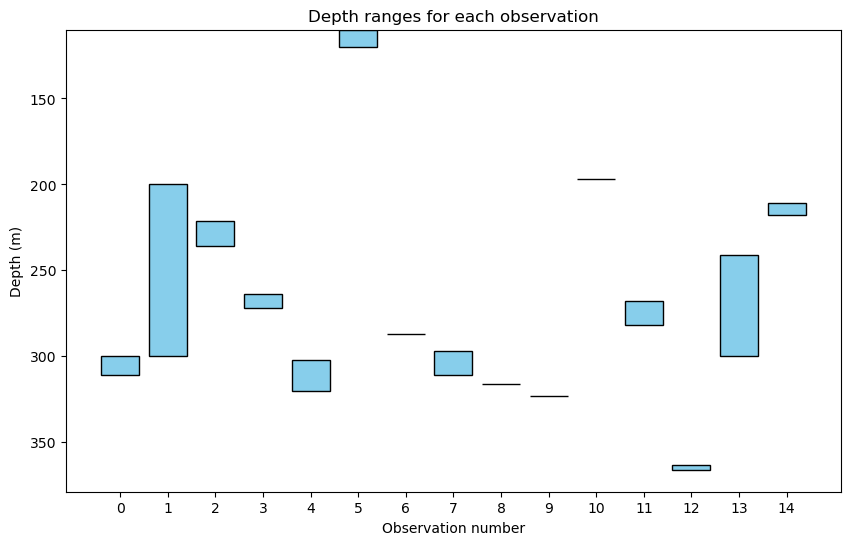

Number of coral data entries without depth data: 89 out of 104


In [2]:
import matplotlib.pyplot as plt
import numpy as np

coral_data_drop_depth_data = coral_data[(coral_data['minimumsdybde'] != 0) & (coral_data['maksimumsdybde'] != 0)]

observation_numbers = np.arange(0, len(coral_data_drop_depth_data))
min_depths = coral_data_drop_depth_data['minimumsdybde'].values  
max_depths = coral_data_drop_depth_data['maksimumsdybde'].values 
depth_ranges = max_depths - min_depths

plt.figure(figsize=(10, 6))
plt.bar(observation_numbers, depth_ranges, bottom=min_depths, color='skyblue', edgecolor='black')

plt.xlabel("Observation number")
plt.ylabel("Depth (m)")
plt.title("Depth ranges for each observation")
plt.xticks(observation_numbers)
plt.gca().invert_yaxis()  
plt.show()

missing_depth_data_count = coral_data[(coral_data['minimumsdybde'] == 0) | (coral_data['maksimumsdybde'] == 0)].shape[0]
print(f"Number of coral data entries without depth data: {missing_depth_data_count} out of {len(coral_data)}")

# Exploring SINMOD data

- PCA

# Exploring SINMOD and Coral data

- Histograms of features at coral data locations (and randomly sampled histograms)
- PLS


In [13]:
from netCDF4 import Dataset
import geopandas as gpd

# # Importing SINMOD data
# filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/gin/spinup/run2/PhysStates.nc'

# PhysStates_data = Dataset(filename_PhysStates, 'r')

# filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/nor4km_2019/2019/PhysStates.nc'

# nor4km_PhysStates_data = Dataset(filename_PhysStates, 'r')

filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'

midnor_PhysStates_data = Dataset(filename_PhysStates, 'r')

# # Import coral data
# coral_data = gpd.read_file('./processed_data/coral_data_trondelag_processed.parquet')

# nor4km_coral_data = gpd.read_file('./processed_data/nor4km_coral_data_trondelag_processed.parquet')

midnor_coral_data = gpd.read_file('./processed_data/midnor_coral_data_trondelag_processed.parquet')

In [ ]:
# Now plot histogram of temperature values at coral data points
import random
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, generate_random=False, save=False, save_path="midnor"):

    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    if t_stop == -1:
        t_stop = netcdf_data.variables['time'].shape[0]

    # Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):

        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            # Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    if (x, y) not in valid_coordinates:
                        valid_coordinates.append((x, y))

    # Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    # Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    # Calculate statistics for coral values
    stats = {
        'mean': np.mean(coral_values_flat),
        'max': np.max(coral_values_flat),
        'min': np.min(coral_values_flat),
        '90th_percentile': np.percentile(coral_values_flat, 90),
        '10th_percentile': np.percentile(coral_values_flat, 10)
    }

    print(f"Statistics for coral values: {stats}")

    # Plot histogram of the combined variable values
    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points - {save_path.capitalize()}')
    
    if save:
        plt.savefig(f'plots/variable_histograms/{variable_name}_histogram_coral_points_{save_path}.png')
    
    plt.show()

    print(f"Number of valid coordinates: {len(valid_coordinates)} out of {len(coral_data)}")

    if generate_random:
        # Plotting random histogram

        no_points = int(len(valid_coordinates))

        # Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        random_values = []
        random_valid_coordinates = []

        for time in range(t_start, t_stop):

            selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

            for y, x in selected_indices:
                
                # Ensure the coordinates are within the grid bounds
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        if (int(x), int(y)) not in random_valid_coordinates:
                            random_valid_coordinates.append((int(x), int(y)))
        
        # Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        # Flatten the array to combine all time steps
        random_values_flat = random_values.flatten()

        # Plot histogram of the combined random variable values
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values - {save_path.capitalize()}')
        
        if save:
            plt.savefig(f'plots/variable_histograms/{variable_name}_histogram_coral_points_{save_path}_random.png')
        
        plt.show()

        print(f"Number of valid random coordinates: {len(random_valid_coordinates)}")

        random_stats = {
            'mean': np.mean(random_values_flat),
            'max': np.max(random_values_flat),
            'min': np.min(random_values_flat),
            '90th_percentile': np.percentile(random_values_flat, 90),
            '10th_percentile': np.percentile(random_values_flat, 10)
        }

        print(f"Statistics for random values: {random_stats}")

        return coral_values, stats, random_values, random_stats
    return coral_values, stats

# Example usage
# plot_histogram_at_coral_points(PhysStates_data, coral_data, 'temperature', (0, 50))
# plot_histogram_at_coral_points(nor4km_PhysStates_data, nor4km_coral_data, 'temperature', (0, 50))
# midnor_temp, midnor_stats, midnor_temp_random, midnor_random_stats = plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'temperature', (0, 10), True)
# plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'salinity', (0, 50))

Statistics for coral values: {'mean': np.float32(8.471743), 'max': np.float32(15.424055), 'min': np.float32(2.976715), '90th_percentile': np.float32(9.336467), '10th_percentile': np.float32(7.6836452)}


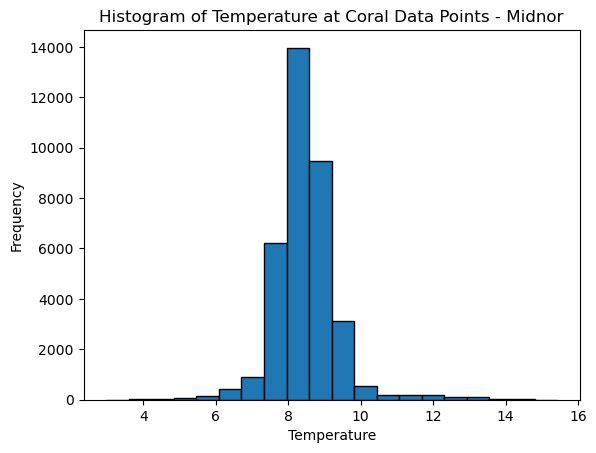

Number of valid coordinates: 98 out of 104


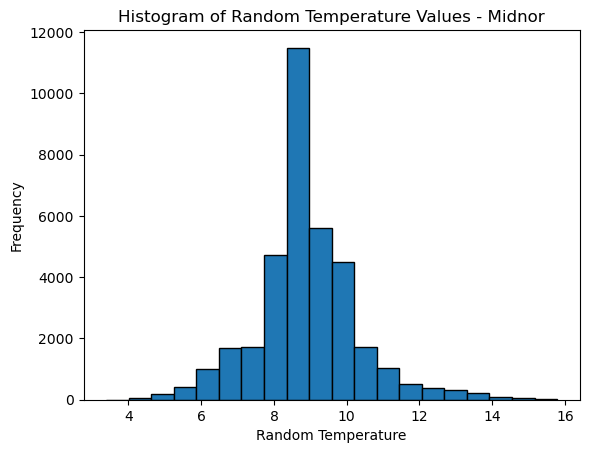

Number of valid random coordinates: 98
Statistics for random values: {'mean': np.float32(8.894311), 'max': np.float32(15.783502), 'min': np.float32(3.3885307), '90th_percentile': np.float32(10.486221), '10th_percentile': np.float32(7.180499)}


In [ ]:
# Plot histogram for temperature
midnor_temp, midnor_temp_stats, midnor_temp_random, midnor_temp_random_stats = plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'temperature', (0, -1), generate_random=True, save=True, save_path="midnor")
midnor_salinity, midnor_salinity_stats, midnor_salinity_random, midnor_salinity_random_stats = plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'salinity', (0, -1), generate_random=True, save=True, save_path="midnor")
midnor_current_speed, midnor_current_speed_stats, midnor_current_speed_random, midnor_current_speed_random_stats = plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'current_speed', (0, -1), generate_random=True, save=True, save_path="midnor")

In [ ]:
def get_statistics(netcdf_data, variable_name, time_range=(0, 50), layer_range=(12,13)):
    variable_data = netcdf_data.variables[variable_name][time_range, layer_range,:,:]
    
    # Masked array to handle missing values
    variable_data = np.ma.masked_array(variable_data, mask=variable_data == netcdf_data.variables[variable_name]._FillValue)
    
    mean_val = np.mean(variable_data)
    max_val = np.max(variable_data)
    min_val = np.min(variable_data)
    percentile_90 = np.percentile(variable_data.compressed(), 90)
    percentile_10 = np.percentile(variable_data.compressed(), 10)
    
    return {
        'mean': mean_val,
        'max': max_val,
        'min': min_val,
        '90th_percentile': percentile_90,
        '10th_percentile': percentile_10
    }

# Example usage
stats = get_statistics(midnor_PhysStates_data, 'temperature')
print(stats)

{'mean': np.float64(8.162505648175168), 'max': np.float32(10.002991), 'min': np.float32(-1.8008366), '90th_percentile': np.float32(9.385662), '10th_percentile': np.float32(6.7949467)}


/tmp/ipykernel_3073113/3213363992.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


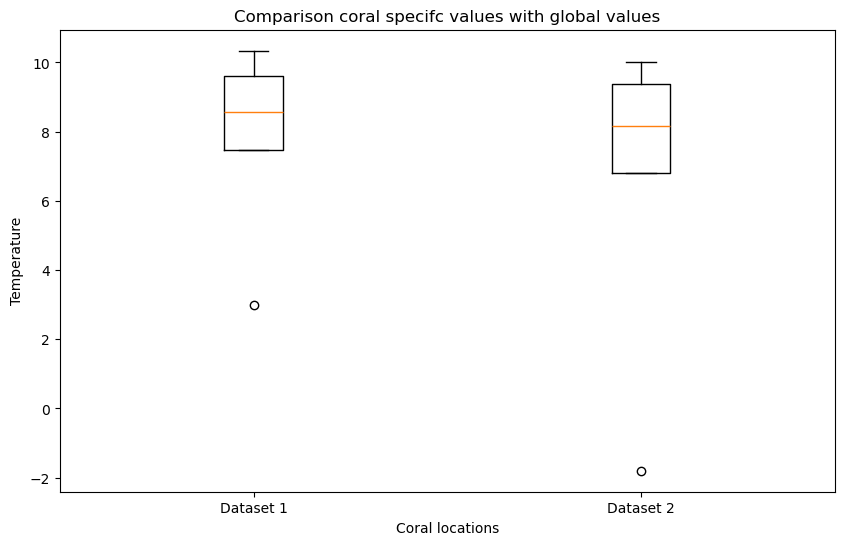

In [ ]:
def plot_stats(stats_list, labels, variable_name='temperature'):
    """
    Plots a list of statistics dictionaries as box and whisker plots.

    Parameters:
    stats_list (list of dict): List of statistics dictionaries.
    labels (list of str): List of labels for each set of statistics.
    """
    # Extract the keys from the first dictionary to use as x-axis labels
    keys = stats_list[0].keys()
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for boxplot
    data = []
    for stats in stats_list:
        values = [stats[key] for key in keys]
        data.append(values)
    
    # Create boxplot
    ax.boxplot(data, labels=labels)
    
    # Set the labels and title
    ax.set_xlabel('Coral locations')
    ax.set_ylabel(variable_name.capitalize())
    ax.set_title('Comparison coral specifc values with global values')
    
    # Show the plot
    plt.show()

# Example usage
stats_list = [midnor_stats, stats]
labels = ['Dataset 1', 'Dataset 2']
plot_stats(stats_list, labels)

